In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks
 assignment0.ipynb
'assignment2_(release).ipynb'
 assignment2_sol.ipynb
 corpus
 datasets
'Deep Q-learning.ipynb'
 f_test.dec
 f_test.enc
 f_train.dec
 f_train.enc
 Glove_solution.ipynb
 loss_female_epo200.npy
 loss_female_epo2.npy
 loss_female_epo40.npy
 loss_female_epo4.npy
 loss_female_epo5.npy
 loss_female_sche_sampling_epo1.npy
 loss_female_sche_sampling_epo200.npy
 loss_female_sche_sampling_epo2.npy
 los

In [0]:
# coding: utf-8
# - try to implrment data.py
corpus_path = 'corpus/'  #cornell movie-dialogs corpus
save_path = 'datasets/'

EN_WHITELIST = '0123456789abcdefghijklmnopqrstuvwxyz ' 
EN_BLACKLIST = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\''

limit = {
        'maxq' : 25,
        'minq' : 2,
        'maxa' : 25,
        'mina' : 2
        }

UNK = 'unk'
VOCAB_SIZE = 8997

# idx2w[0]='_'    ...zero padding
# idx2w[1]='unk'
# idx2w[2]='<G0>'
# idx2w[3]='<EOS>'
# total 9000

import random
import nltk
import itertools
from collections import defaultdict
import numpy as np
import pickle

''' 
    1. Read from 'movie_characters_metadata.txt'
    2. Create a dictionary with ( key = u_id, value = gender )
'''
def get_character2gender():
    lines=open(corpus_path+'movie_characters_metadata.txt', encoding='utf-8', errors='ignore'
               ).read().split('\n') #encoding='utf-8', errors='ignore'
    c2g = {} #Create a dictionary
    for line in lines:
        _line = line.split(' +++$+++ ')
        if len(_line) == 6: #Conform to the format
            c2g[ _line[0] ] = _line[4] #Update the dictionary
            #_line[0]='u0', _line[4]='f'
    return c2g

''' 
    1. Read from 'movie-lines.txt'
    2. Create a dictionary with ( key = line_id, value = text )
'''
def get_id2line():
    lines=open(corpus_path+'movie_lines.txt', encoding='utf-8', errors='ignore'
               ).read().split('\n') #encoding='utf-8', errors='ignore'
    id2line = {} #Create a dictionary
    for line in lines:
        _line = line.split(' +++$+++ ')
        if len(_line) == 5: 
            id2line[ _line[0] ] = _line[4] #Update the dictionary
            #_line[0]='L1045', _line[4]='They do not!'
    return id2line

''' 
    1. Read from 'movie-lines.txt'
    2. Create a dictionary with ( key = line_id, value = gender )
'''
def get_id2gender(u2gender):
    lines=open(corpus_path+'movie_lines.txt', encoding='utf-8', errors='ignore'
               ).read().split('\n') #encoding='utf-8', errors='ignore'
    id2gender = {} #Create a dictionary
    for line in lines:
        _line = line.split(' +++$+++ ')
        if len(_line) == 5:
            id2gender[ _line[0] ] = u2gender [ _line[1] ] #Update the dictionary
            #_line[0]='L1045', _line[4]='They do not!'
    return id2gender

'''
    1. Read from 'movie_conversations.txt'
    2. Create a list of [list of line_id's]
'''
def get_conversations():
    conv_lines = open(corpus_path+'movie_conversations.txt', encoding='utf-8', errors='ignore'
                      ).read().split('\n') #encoding='utf-8', errors='ignore'
    convs = [ ] #Create a list
    for line in conv_lines[:-1]:
        _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
        #_line[-1]= "'L194', 'L195', 'L196', 'L197'"
        #[1:-1]: remove '[',']' 
        #_line = 'L194,L195,L196,L197'
        #_line.split(',')=['L194', 'L195', 'L196', 'L197']
        convs.append(_line.split(','))
    return convs

'''
花時間!!暫時不需要!!!
    1. Get each conversation
    2. Get each line from conversation
    3. Save each conversation to file
'''
def extract_conversations(convs,id2line,path=''):
    idx = 0
    for conv in convs:
        f_conv = open(path + str(idx)+'.txt', 'w')#create file for each conv
        for line_id in conv:
            f_conv.write(id2line[line_id])
            f_conv.write('\n')
        f_conv.close()
        idx += 1

'''
    Get lists of all conversations as Questions and Answers
    1. [questions]
    2. [answers]
'''
def gather_dataset(convs, id2line):
    questions = []; answers = []

    for conv in convs:
        '''
        #Put['L194', 'L195', 'L196', 'L197']Divide
        #['L194', 'L195']和[ 'L196', 'L197']
        #130,000 total
        if len(conv) %2 != 0:
            conv = conv[:-1] #Only get an even number
        for i in range(len(conv)):
            if i%2 == 0:
                questions.append(id2line[conv[i]])
            else:
                answers.append(id2line[conv[i]])
        '''
        for i in range(len(conv)-1):
            questions.append(id2line[conv[i]])
            answers.append(id2line[conv[i+1]])  
            #Put['L194', 'L195', 'L196', 'L197']Divide
            #['L194', 'L195'],['L195', 'L196'] with [ 'L196', 'L197']
            #220,000 pens

    return questions, answers

'''
    Get lists of Pratial conversations as Questions and Answers By Gender
    1. [questions]
    2. [answers]
'''
def gather_dataset_by_gender(convs, id2line, id2gender,
                             que_gender='?', ans_gender='?' ): 
    #if ans_gender = 'f', just female answer
    #if ans_gender = 'm', just male answer
    #if ans_gender = '?', both male/female answer, including gender unknown
    
    questions = []; answers = []

    for conv in convs:
        for i in range(len(conv)-1):
            # check gender
            bool_1 = que_gender == id2gender[conv[i]] 
            bool_2 = ans_gender == id2gender[conv[i+1]] 
            bool_3 = que_gender == '?' 
            bool_4 = ans_gender == '?' 
            bool_que = bool_1 or bool_3 
            bool_ans = bool_2 or bool_4 
            if ( bool_que and bool_ans ) :    
                questions.append(id2line[conv[i]])
                answers.append(id2line[conv[i+1]])  
                #Put ['L194', 'L195', 'L196', 'L197'] Divide
                #['L194', 'L195'],['L195', 'L196'] iwth [ 'L196', 'L197']
                #220,000 pens
    return questions, answers

'''
暫時沒用到!!!
    Shuffle and split to train/test dataset
    We need 4 files
        1. train.enc : Encoder input for training
        2. train.dec : Decoder input for training
        3. test.enc  : Encoder input for testing
        4. test.dec  : Decoder input for testing
    -> Encoder input is question, and Decoder input is answer 
'''
def prepare_seq2seq_files(questions, answers, gender = 'f' ,
                          path='',TESTSET_SIZE = 10000):
    
    # open files
    train_enc = open(path + gender+'_train.enc','w')
    train_dec = open(path + gender+'_train.dec','w')
    test_enc  = open(path + gender+'_test.enc', 'w')
    test_dec  = open(path + gender+'_test.dec', 'w')

    # choose 10,000 (TESTSET_SIZE) items to put into testset
    test_ids = random.sample([i for i in range(len(questions))],TESTSET_SIZE)

    for i in range(len(questions)):
        if i in test_ids:
            test_enc.write(questions[i]+'\n')
            test_dec.write(answers[i]+ '\n' )
        else:
            train_enc.write(questions[i]+'\n')
            train_dec.write(answers[i]+ '\n' )
        if i%10000 == 0:
            print('>> written {} lines'.format(i))

    # close files
    train_enc.close()
    train_dec.close()
    test_enc.close()
    test_dec.close()
    print('>>written finish')

'''
 remove anything that isn't in the vocabulary
    return str(pure en)
'''
def filter_line(line, whitelist): # whitelist:Safe list / only left whitelist
    return ''.join([ ch for ch in line if ch in whitelist ])

#filter_line('fweijwhf8328r8uAAAgerg19,,',EN_WHITELIST)

'''
 filter too long and too short sequences
    return tuple( filtered_ta, filtered_en )
'''
def filter_data(qseq, aseq):
    filtered_q, filtered_a = [], []
    raw_data_len = len(qseq)

    assert len(qseq) == len(aseq)

    for i in range(raw_data_len):
        qlen, alen = len(qseq[i].split(' ')), len(aseq[i].split(' '))
        if qlen >= limit['minq'] and qlen <= limit['maxq']:
            if alen >= limit['mina'] and alen <= limit['maxa']:
                filtered_q.append(qseq[i])
                filtered_a.append(aseq[i])

    # print the fraction of the original data, filtered
    filt_data_len = len(filtered_q)
    filtered = int((raw_data_len - filt_data_len)*100/raw_data_len)
    print(str(filtered) + '% filtered from original data')

    return filtered_q, filtered_a

'''
 read list of words, create index to word,
  word to index dictionaries
    return tuple( vocab->(word, count), idx2w, w2idx )
'''
def index_(tokenized_sentences, vocab_size):
    # get frequency distribution
    freq_dist = nltk.FreqDist(itertools.chain(*tokenized_sentences))
    # get vocabulary of 'vocab_size' most used words
    vocab = freq_dist.most_common(vocab_size)
    # index2word (as a list)
    index2word = ['_'] + [UNK] + [ x[0] for x in vocab ]
    # word2index (as a dict)
    word2index = dict([(w,i) for i,w in enumerate(index2word)] )
    return index2word, word2index, freq_dist

'''
 filter based on number of unknowns (words not in vocabulary)
  filter out the worst sentences
'''
def filter_unk(qtokenized, atokenized, w2idx):
    data_len = len(qtokenized)

    filtered_q, filtered_a = [], []

    for qline, aline in zip(qtokenized, atokenized):
        unk_count_q = len([ w for w in qline if w not in w2idx ])
        unk_count_a = len([ w for w in aline if w not in w2idx ])
        if unk_count_a <= 2:
            if unk_count_q > 0:
                if unk_count_q/len(qline) > 0.2:
                    pass
            filtered_q.append(qline)
            filtered_a.append(aline)

    # print the fraction of the original data, filtered
    filt_data_len = len(filtered_q)
    filtered = int((data_len - filt_data_len)*100/data_len)
    print(str(filtered) + '% filtered from original data')

    return filtered_q, filtered_a

'''
 create the final dataset : 
  - convert list of items to arrays of indices
  - add zero padding
      return ( [array_en([indices]), array_ta([indices]) )
 
'''
def zero_pad(qtokenized, atokenized, w2idx):
    # num of rows
    data_len = len(qtokenized)

    # numpy arrays to store indices
    idx_q = np.zeros([data_len, limit['maxq']], dtype=np.int32) 
    idx_a = np.zeros([data_len, limit['maxa']], dtype=np.int32)

    for i in range(data_len):
        q_indices = pad_seq(qtokenized[i], w2idx, limit['maxq'])
        a_indices = pad_seq(atokenized[i], w2idx, limit['maxa'])

        #print(len(idx_q[i]), len(q_indices))
        #print(len(idx_a[i]), len(a_indices))
        idx_q[i] = np.array(q_indices)
        idx_a[i] = np.array(a_indices)

    return idx_q, idx_a

'''
 replace words with indices in a sequence
  replace with unknown if word not in lookup
    return [list of indices]
'''
def pad_seq(seq, lookup, maxlen):
    indices = []
    for word in seq:
        if word in lookup:
            indices.append(lookup[word])
        else:
            indices.append(lookup[UNK])
    return indices + [0]*(maxlen - len(seq))

'''
    main process
    for chatbot
'''
def process_data(): 
    
    u2gender = get_character2gender()
    print('>> gathered u2gender dictionary.\n')
    id2line = get_id2line()
    print('>> gathered id2line dictionary.\n')
    id2gender = get_id2gender(u2gender)
    print('>> gathered id2gender dictionary.\n')
    convs = get_conversations() # [ ['L750', 'L751'], [...] ,... ]
    print('>> gathered all conversations.\n')
    #questions, answers = gather_dataset(convs,id2line)
    f_questions, f_answers = gather_dataset_by_gender(convs, 
                                                  id2line, id2gender,
                                                  ans_gender='f')
    m_questions, m_answers = gather_dataset_by_gender(convs, 
                                                  id2line, id2gender,
                                                  ans_gender='m')
    print('\n Female dataset len : ' + str(len(f_questions)))
    print('\n Male dataset len : ' + str(len(m_questions)))
    
    
    # change to lower case (just for en)
    f_questions = [ line.lower() for line in f_questions ]
    f_answers = [ line.lower() for line in f_answers ]
    m_questions = [ line.lower() for line in m_questions ]
    m_answers = [ line.lower() for line in m_answers ]
    
    # filter out unnecessary characters #Blanks cannot be filtered out, otherwise they cannot be separated
    # Make sure all characters in the sentence are on the safe list
    print('\n>> Filter lines')
    f_questions = [ filter_line(line, EN_WHITELIST) for line in f_questions ]
    f_answers = [ filter_line(line, EN_WHITELIST) for line in f_answers ]
    m_questions = [ filter_line(line, EN_WHITELIST) for line in m_questions ]
    m_answers = [ filter_line(line, EN_WHITELIST) for line in m_answers ]
    
    # filter out too long or too short sequences
    print('\n>> Filter out too long or too short sequences')
    f_qlines, f_alines = filter_data(f_questions, f_answers)
    m_qlines, m_alines = filter_data(m_questions, m_answers)
    print('\n Female dataset len : ' + str(len(f_qlines)))
    print('\n Male dataset len : ' + str(len(m_qlines)))

    print('\n Before token : ')
    for q,a in zip(f_qlines[141:145], f_alines[141:145]):
        print('q : [{0}]; a : [{1}]'.format(q,a))

    # tokenize: convert list of [lines of text] into list of [list of words ]
    print('\n>> Segment lines into words')
    f_qtokenized = [ [w.strip() for w in wordlist.split(' ') if w] 
                  for wordlist in f_qlines ]
    f_atokenized = [ [w.strip() for w in wordlist.split(' ') if w] 
                  for wordlist in f_alines ]
    m_qtokenized = [ [w.strip() for w in wordlist.split(' ') if w] 
                  for wordlist in m_qlines ]
    m_atokenized = [ [w.strip() for w in wordlist.split(' ') if w] 
                  for wordlist in m_alines ]
    print('\n:: Sample from segmented list of words')
    
    print('\n After token : ')
    for q,a in zip(f_qtokenized[141:145], f_atokenized[141:145]):
        print('q : [{0}]; a : [{1}]'.format(q,a))

    # indexing -> idx2w, w2idx 
    all_tokenized = f_qtokenized + f_atokenized + m_qtokenized + m_atokenized
    print('\n >> Index words')
    idx2w, w2idx, freq_dist = index_( all_tokenized, 
                                     vocab_size=VOCAB_SIZE)
    
    # filter out sentences with too many unknown words
    print('\n >> Filter out sentences with too many unknown words')
    f_qtokenized, f_atokenized = filter_unk(f_qtokenized, f_atokenized, w2idx)
    m_qtokenized, m_atokenized = filter_unk(m_qtokenized, m_atokenized, w2idx)
    print('\n Final Female dataset len : ' + str(len(f_qtokenized)))
    print('\n Final Male dataset len : ' + str(len(m_qtokenized)))

    print('\n >> Zero Padding')
    f_idx_q, f_idx_a = zero_pad(f_qtokenized, f_atokenized, w2idx)
    m_idx_q, m_idx_a = zero_pad(m_qtokenized, m_atokenized, w2idx)
    
    print('\n >> Save numpy arrays to disk')
    # save them
    np.save(save_path+'f_idx_q.npy', f_idx_q)
    np.save(save_path+'f_idx_a.npy', f_idx_a)
    np.save(save_path+'m_idx_q.npy', m_idx_q)
    np.save(save_path+'m_idx_a.npy', m_idx_a)
    
    # let us now save the necessary dictionaries
    metadata = {
            'w2idx' : w2idx,
            'idx2w' : idx2w,
            'limit' : limit,
            'freq_dist' : freq_dist
                }

    # write to disk : data control dictionaries
    with open(save_path+'metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)

    # count of unknowns
    unk_count = (f_idx_q == 1).sum() + (f_idx_a == 1).sum() + (m_idx_q == 1).sum() + (m_idx_a == 1).sum()
    # count of words
    word_count = (f_idx_q > 1).sum() + (f_idx_a > 1).sum() + (m_idx_q > 1).sum() + (m_idx_a > 1).sum()

    print('% unknown : {0}'.format(100 * (unk_count/word_count)))
    print('Female Dataset count : ' + str(f_idx_q.shape[0]))
    print('Male Dataset count : ' + str(m_idx_q.shape[0]))

    #print '>> gathered questions and answers.\n'
    #prepare_seq2seq_files(f_idx_q,f_idx_a,'f')
    #prepare_seq2seq_files(m_idx_q,m_idx_a,'m')

if __name__ == '__main__':
    process_data()

'''
    load_data
    for chatbot
'''
def load_data(PATH=''):
    # read data control dictionaries
    with open(PATH + 'metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    # read numpy arrays
    f_idx_q = np.load(PATH + 'f_idx_q.npy')
    f_idx_a = np.load(PATH + 'f_idx_a.npy')
    m_idx_q = np.load(PATH + 'm_idx_q.npy')
    m_idx_a = np.load(PATH + 'm_idx_a.npy')
    return metadata, f_idx_q, f_idx_a, m_idx_q, m_idx_a

def load_data_female(PATH=''):
    # read numpy arrays
    f_idx_q = np.load(PATH + 'f_idx_q.npy')
    f_idx_a = np.load(PATH + 'f_idx_a.npy')
    return f_idx_q, f_idx_a

>> gathered u2gender dictionary.

>> gathered id2line dictionary.

>> gathered id2gender dictionary.

>> gathered all conversations.


 Female dataset len : 48650

 Male dataset len : 113671

>> Filter lines

>> Filter out too long or too short sequences
29% filtered from original data
29% filtered from original data

 Female dataset len : 34164

 Male dataset len : 79827

 Before token : 
q : [so tell me about this dance was it fun]; a : [parts of it]
q : [which parts]; a : [the part where bianca beat the hell out of some guy]
q : [bianca did what]; a : [whats the matter  upset that i rubbed off on her]
q : [katarina stratford  my my  youve been terrorizing ms blaise again]; a : [expressing my opinion is not a terrorist action]

>> Segment lines into words

:: Sample from segmented list of words

 After token : 
q : [['so', 'tell', 'me', 'about', 'this', 'dance', 'was', 'it', 'fun']]; a : [['parts', 'of', 'it']]
q : [['which', 'parts']]; a : [['the', 'part', 'where', 'bianca', 'beat',

In [0]:
!ls

 assignment0.ipynb
'assignment2_(release).ipynb'
 assignment2_sol.ipynb
 corpus
 datasets
'Deep Q-learning.ipynb'
 f_test.dec
 f_test.enc
 f_train.dec
 f_train.enc
 Glove_solution.ipynb
 loss_female_epo200.npy
 loss_female_epo2.npy
 loss_female_epo40.npy
 loss_female_epo4.npy
 loss_female_epo5.npy
 loss_female_sche_sampling_epo1.npy
 loss_female_sche_sampling_epo200.npy
 loss_female_sche_sampling_epo2.npy
 loss_male_epo200.npy
 loss_male_epo2.npy
 loss_male_epo5.npy
 loss_male_prob_feed_epo200.npy
 loss.png
 main.py
'Model 4 generator'
'Model 5 RL'
 model_female_prob_feed_epo141.pth
 model_female_prob_feed_epo199.pth
 model_female_prob_feed_epo200.pth
 pth
 Schedule_Sampling_Seq2Seq-female.ipynb
'Schedule Sampling Seq2Seq-Movie_Script Chatbot-PyTorch.ipynb'


Data_add_EOS

In [0]:
import numpy as np
import pickle

In [0]:
def load_data(PATH='datasets/'):
    # read data control dictionaries
    with open(PATH + 'metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    # read numpy arrays
    f_idx_q = np.load(PATH + 'f_idx_q.npy')
    f_idx_a = np.load(PATH + 'f_idx_a.npy')
    m_idx_q = np.load(PATH + 'm_idx_q.npy')
    m_idx_a = np.load(PATH + 'm_idx_a.npy')
    return metadata, f_idx_q, f_idx_a, m_idx_q, m_idx_a

metadata, f_idx_q, f_idx_a, m_idx_q, m_idx_a = load_data(PATH='datasets/')

In [0]:
def add_EOS_metadata(meta, save_path='datasets/'):
    
    # metadata
    idx2w = meta['idx2w']
    w2idx = meta['w2idx']
    eos_idx = len(w2idx)  # eos_idx=8002
    idx2w.append('<EOS>')
    w2idx.update({'<EOS>': eos_idx})
    metadata = {
            'w2idx' : w2idx,
            'idx2w' : idx2w,
                }
    with open(save_path+'metadata_1.pkl', 'wb') as f:
        pickle.dump(metadata, f)
        
    return eos_idx

In [0]:
def add_EOS_line(idxs, eos_idx=8002):
    new_idxs = np.copy(idxs)
    for i,line in enumerate(idxs):
        zreo_pos_arr = np.where(line==0)[0]
        if len(zreo_pos_arr)>0:
            new_idxs[i,25-len(zreo_pos_arr)]=eos_idx
    return new_idxs

In [0]:
def idxs_add_EOS(f_idx_q, f_idx_a, m_idx_q, m_idx_a, eos_idx=8002, save_path='datasets/'):
    
    f_idx_q_1 = add_EOS_line(f_idx_q, eos_idx=eos_idx)
    f_idx_a_1 = add_EOS_line(f_idx_a, eos_idx=eos_idx)
    m_idx_q_1 = add_EOS_line(m_idx_q, eos_idx=eos_idx)
    m_idx_a_1 = add_EOS_line(m_idx_a, eos_idx=eos_idx)
    np.save(save_path+'f_idx_q_1.npy', f_idx_q_1)
    np.save(save_path+'f_idx_a_1.npy', f_idx_a_1)
    np.save(save_path+'m_idx_q_1.npy', m_idx_q_1)
    np.save(save_path+'m_idx_a_1.npy', m_idx_a_1)
    
idxs_add_EOS(f_idx_q, f_idx_a, m_idx_q, m_idx_a)

In [0]:
def add_EOS(path='datasets/'):
    metadata, f_idx_q, f_idx_a, m_idx_q, m_idx_a  = load_data()
    eos_idx = add_EOS_metadata(metadata)
    idxs_add_EOS(f_idx_q, f_idx_a, m_idx_q, m_idx_a, eos_idx=eos_idx)
    
    
    f_idx_q_1 = np.load('datasets/f_idx_q_1.npy')
    print(f_idx_q_1 [0])
    print(f_idx_q [0])
    print(f_idx_q_1 [350])
    print(f_idx_q [350])
    
add_EOS()

[  41    3  133  666  327   34    1   46   44  108   34    2 8999    0
    0    0    0    0    0    0    0    0    0    0    0]
[ 41   3 133 666 327  34   1  46  44 108  34   2   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[   3   14   18   20    4  674  284    3  180    3   33  133    2   18
  666 2753    6  212 1750   31 1386   35   27  309    5]
[   3   14   18   20    4  674  284    3  180    3   33  133    2   18
  666 2753    6  212 1750   31 1386   35   27  309    5]


## Seq2Seq-female

In [0]:
import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import pickle

### Data Handling
load data

In [0]:
ans = np.load("./datasets/f_idx_a_1.npy")
ques = np.load("./datasets/f_idx_q_1.npy")

with open('./datasets/metadata_1.pkl', 'rb') as f:
        metadata = pickle.load(f)

In [0]:
class FemaleDataset(data.Dataset): 
    def __init__(self,ques,ans):
        self.ques = ques
        self.ans = ans
    
    def __getitem__(self, index):
        ques_tensor = torch.from_numpy(self.ques[index]).long()
        ans_tensor = torch.from_numpy(self.ans[index]).long()
        
        return ques_tensor , ans_tensor
    
    def __len__(self):
        return 33589      

### Define Model

In [0]:
batch_size = 32

female_dataset = FemaleDataset(ques,ans)
train_loader = torch.utils.data.DataLoader(dataset=female_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

In [0]:
GO = Variable(torch.zeros(32,1,256)).cuda()
GO.shape

torch.Size([32, 1, 256])

In [0]:
inputs = GO
inputs.shape

torch.Size([32, 1, 256])

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 src_voc_size=9000,
                 trg_voc_size=9000,
                 src_embedding_size=256,
                 trg_embedding_size=256,
                 enc_hidden_size=200,
                 dec_hidden_size=200):
        
        super(Seq2Seq, self).__init__()
        self.trg_embedding_size = trg_embedding_size
        self.dec_hidden_size = dec_hidden_size
        
        self.src_embedder = nn.Embedding(src_voc_size , src_embedding_size)
        self.encoder = nn.LSTM(src_embedding_size ,enc_hidden_size,3, batch_first=True,dropout=0.5)
        
        self.trg_embedder = nn.Embedding(trg_voc_size , trg_embedding_size)
        self.decoder = nn.LSTM(trg_embedding_size ,dec_hidden_size,3, batch_first=True,dropout=0.5)
        self.cls = nn.Linear(dec_hidden_size , trg_voc_size)
    
    def forward(self,source,target,feed_previous=False):
        batch_size = source.size()[0]
        src_em = self.src_embedder(source)
        trg_em = self.trg_embedder(target)
        
        _ , enc_state = self.encoder(src_em)
        
        GO = Variable(torch.zeros(batch_size,1,self.trg_embedding_size)).cuda()
        dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
        if feed_previous: #test phase
            logits_ = []
#            inputs = torch.unsqueeze(dec_in[:,i,:],1)
            h = enc_state
            for i in range(25):
                inputs = torch.unsqueeze(dec_in[:,i,:],1)
                output , h = self.decoder(inputs,h)
                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
                logits_.append(logits)
                
                predicted = logits.max(1)[1]
                inputs = self.trg_embedder(predicted)
                    
            return torch.cat(logits_,0)

        else: #train phase
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
            outputs , _ = self.decoder(dec_in,enc_state)
            outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
            logits = self.cls(outputs)
        
            return logits

        # else: #train phase -- schedule sampling
        #     '''
        #     dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)  # trg_em.shape=(batch_size, time step, trg_embedding_size )
        #     outputs , _ = self.decoder(dec_in,enc_state)
        #     outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
        #     logits = self.cls(outputs)        
        #     return logits  
        #     '''
        #     logits_ = []
        #     dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
            
        #     h = enc_state
        #     for i in range(25):
        #         inputs = torch.unsqueeze(dec_in[:,i,:],1)
                
        #         if i < 5:
        #             inputs =  torch.unsqueeze(dec_in[:,i,:],1)
        #         else:
        #             if random.random() < 0.5 : 
        #                 inputs =  torch.unsqueeze(dec_in[:,i,:],1)  #usual training policy 
        #             else:
        #                 inputs = self.trg_embedder(predicted)  #schedule sampling
                
        #         output , h = self.decoder(inputs,h)
        #         logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
        #         logits_.append(logits)
        #         predicted = logits.max(1)[1]  # predicted.shape=(batch_size, time step=1)
                
        #     return torch.cat(logits_,0)

In [0]:
# class Seq2Seq(nn.Module):
#     def __init__(self,
#                  src_voc_size=9000,
#                  trg_voc_size=9000,
#                  src_embedding_size=256,
#                  trg_embedding_size=256,
#                  enc_hidden_size=200,
#                  dec_hidden_size=200):
        
#         super(Seq2Seq, self).__init__()
#         self.trg_embedding_size = trg_embedding_size
#         self.dec_hidden_size = dec_hidden_size
        
#         self.src_embedder = nn.Embedding(src_voc_size , src_embedding_size)
#         self.encoder = nn.LSTM(src_embedding_size ,enc_hidden_size,3, batch_first=True,dropout=0.5)
        
#         self.trg_embedder = nn.Embedding(trg_voc_size , trg_embedding_size)
#         self.decoder = nn.LSTM(trg_embedding_size ,dec_hidden_size,3, batch_first=True,dropout=0.5)
#         self.cls = nn.Linear(dec_hidden_size , trg_voc_size)
    
#     def forward(self,source,target,feed_previous=False):
#         batch_size = source.size()[0]
#         src_em = self.src_embedder(source)
#         trg_em = self.trg_embedder(target)
        
#         _ , enc_state = self.encoder(src_em)
        
#         GO = Variable(torch.zeros(batch_size,1,self.trg_embedding_size)).cuda()
        
#         if feed_previous: #test phase
#             logits_ = []
#             inputs = GO
#             h = enc_state
#             for i in range(25):
#                 inputs = torch.cat([GO,trg_em[:,:-1,:]],1) # I modify this part
#                 output , h = self.decoder(inputs,h)
#                 logits = self.cls(output.reshape(-1, self.dec_hidden_size))
# #                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
#                 logits_.append(logits)
                
#                 predicted = logits.max(1)[1]
#                 inputs = self.trg_embedder(predicted)
                    
#             return torch.cat(logits_,0)      
            
#         else: #train phase
#             dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
#             outputs , _ = self.decoder(dec_in,enc_state)
#             outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
#             logits = self.cls(outputs)
        
#             return logits

In [0]:
model = Seq2Seq().cuda()

In [0]:
model.train()

Seq2Seq(
  (src_embedder): Embedding(9000, 256)
  (encoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (trg_embedder): Embedding(9000, 256)
  (decoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (cls): Linear(in_features=200, out_features=9000, bias=True)
)

### Training

In [0]:
train_op = optim.Adam(model.parameters() ,lr=3e-4)

In [0]:
epochs = 200
loss_hist = []
loss_ = 3
model.train()
for epoch in range(epochs):
    epoch_mean_loss = []

    for i , (q,a) in enumerate(train_loader):
        q = Variable(q).cuda()
        a = Variable(a).cuda()
   
        logits = model(q,a,feed_previous=False)
        _,predict = logits.max(1)
        
        loss = F.cross_entropy(logits ,a.view(-1))
        train_op.zero_grad()
        loss.backward()
        train_op.step()
#        print('loss', loss.data.item())
        epoch_mean_loss.append(loss.data.item())
    
    loss_ = np.mean(epoch_mean_loss)
    loss_hist.append(loss_)
    if epoch % 10 == 0  or epoch == epochs-1:
        print("epoch:%s , loss:%s" % (epoch , loss_ ))
    if epoch % 50 == 0 or epoch == epochs-1:
        torch.save(model.state_dict() , 'pth/model_female_epo%s.pth'%epoch) #save model
        
np.save('loss_female_epo%s.npy'%epochs,loss_hist)

epoch:0 , loss:2.3142165168126425
epoch:1 , loss:1.9915728185290382


In [0]:
_,predict = logits.max(1)

### Print Result

In [0]:
class Vocab:
    def __init__(self,idx2word,word2idx):
        self.idx2word = idx2word
        self.word2idx = word2idx
        self.max_len = 25
        self.eos_idx = 8002
        self.EN_WHITELIST  = '0123456789abcdefghijklmnopqrstuvwxyz '             
            
    '''
    idx -> word with EOS
    '''        
    def decode_line(self,sentence_idx,remove_pad=True,remove_eos=True):  #sentence_idx: 1d_matrix     
        sentence = []
        for w in sentence_idx:
            if remove_eos and w==self.eos_idx:
                continue
            if remove_pad and w==0 : 
                continue
            sentence.append(self.idx2word[w])
            #if w==self.eos_idx:
            #    break
        sentence = ' '.join(sentence)
        return sentence
    
    def decode(self,sentence_idxs,remove_pad=True,remove_eos=True): #sentence_idxs: 2d_matrix 
        sentences = []
        for s in sentence_idxs: 
            sentences.append(self.decode_line(s,
                                              remove_pad=remove_pad,
                                              remove_eos=remove_eos))
        return sentences
            
    '''
    word -> idx with EOS
    '''
    def encode_line(self,sentence):  #sentence: 1d_matrix
        sentence = sentence.lower()
        s_list = ''.join([ ch for ch in sentence if ch in self.EN_WHITELIST ]).split()
        sentence_idx = []
        for w in s_list:
            sentence_idx.append(self.word2idx[w])
        n = len(sentence_idx)
        if  n > self.max_len:
            sentence_idx = sentence_idx[:self.max_len] 
        elif n < self.max_len:
            sentence_idx = sentence_idx + [self.eos_idx] + [0]*(self.max_len-n-1)  
        return sentence_idx
    
    def encode(self,sentences): #sentences: 2d_matrix   
        sentence_idxs = []
        for s in sentences: 
            sentence_idxs.append(self.encode_line(s))
        return np.array(sentence_idxs)
    
    def print_QA(self, ques , pred_ans, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans[i] , strd_ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[2])
            print('pred A :'+sents[1]) 
            
    def print_QA_1(self, ques , pred_ans_train, pred_ans_test, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans_train[i], pred_ans_test[i] , strd_ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[3])
            print('train A:'+sents[1])    
            print('test A :'+sents[2]) 
            
    def print_QA_2(self, ques , ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i], ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[1])

In [0]:
predict.size()

torch.Size([525])

In [0]:
predict.unsqueeze(1).size()

torch.Size([525, 1])

In [0]:
#predict.unsqueeze(1).cpu().view(-1,21)

In [0]:
#predict.cpu().view(-1,n)

In [0]:
#predict.squeeze(1).shape

In [0]:
n = 525/25
int(n)

21

In [0]:
vocab = Vocab(metadata['idx2w'] , metadata['w2idx'])

### Try train corpus

In [0]:
pred_ans = predict.cpu().view(-1,int(n)).data.numpy().T #predicted answer in train phase
strd_ans = a.cpu().view(-1,int(n)).data.numpy().T #standard answer
ques     = q.cpu().view(-1,int(n)).data.numpy().T #quenstions
vocab.print_QA(ques , pred_ans, strd_ans)


Q      :smoke what on of well to about dad my
A      :for might youre dont <EOS> it mark
pred A :i know <EOS> dont you <EOS> unk

Q      :screen we unk this not talk this gave i brother
A      :your think talking watch <EOS> of you
pred A :unk know unk know <EOS> <EOS> i

Q      :for become its coffin like to tell is me cant will
A      :own you about the the quality want
pred A :unk to <EOS> <EOS> i <EOS> dont

Q      :what cowards like we barbie you you them cuff fifty tell feel
A      :fear were <EOS> new whos gear <EOS> me
pred A :<EOS> <EOS> <EOS> unk i unk <EOS> <EOS>

Q      :<EOS> whats included that have <EOS> at helena the an grand you great
A      :<EOS> plan more ones sophie is to
pred A :<EOS> i <EOS> unk unk <EOS> <EOS>

Q      :plan we movie to all <EOS> gear link <EOS> except i now
A      :c into <EOS> <EOS> down tell tell
pred A :you <EOS> <EOS> <EOS> <EOS> know i

Q      :c unk harold prepare actually is i <EOS> only just hes
A      :is eleanor <EOS> i you me
pred A 

In [0]:
# pred_ans = predict.unsqueeze(1).cpu().view(-1,int(n)).data.numpy().T #predicted answer in train phase
# strd_ans = a.cpu().unsqueeze(1).view(-1,int(n)).data.numpy().T #standard answer
# ques     = q.cpu().unsqueeze(1).view(-1,int(n)).data.numpy().T #quenstions
# vocab.print_QA(ques , pred_ans, strd_ans)

### Try test corpus

In [0]:
model.eval()
o = model(q,a,feed_previous=True) #logits
_,predict_test = o.max(1)
#vocab.decode(predict_test.cpu().view(-1,10).data.numpy().T,remove_eos=False,remove_pad=False)
pred_ans_test = predict_test.cpu().view(-1,int(n)).data.numpy().T #predicted answer in test phase
vocab.print_QA_1(ques , pred_ans, pred_ans_test, strd_ans)


Q      :smoke what on of well to about dad my
A      :for might youre dont <EOS> it mark
train A:i know <EOS> dont you <EOS> unk
test A :i unk unk <EOS> <EOS>

Q      :screen we unk this not talk this gave i brother
A      :your think talking watch <EOS> of you
train A:unk know unk know <EOS> <EOS> i
test A :i you <EOS> <EOS> <EOS>

Q      :for become its coffin like to tell is me cant will
A      :own you about the the quality want
train A:unk to <EOS> <EOS> i <EOS> dont
test A :i unk <EOS> <EOS> <EOS> <EOS>

Q      :what cowards like we barbie you you them cuff fifty tell feel
A      :fear were <EOS> new whos gear <EOS> me
train A:<EOS> <EOS> <EOS> unk i unk <EOS> <EOS>
test A :i i <EOS> <EOS> you know <EOS> <EOS> <EOS> know know <EOS> know <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Q      :<EOS> whats included that have <EOS> at helena the an grand you great
A      :<EOS> plan more ones sophie is to
train A:<EOS> i <EOS> unk unk <EOS> <EOS>
test A :i dont <EOS> know <EOS> <EO

In [0]:
q.dim()

2

In [0]:
a.dim()

2

In [0]:
# a.unsqueeze(-3).dim()

In [0]:
q.unsqueeze(-3).dim()

3

In [0]:
model.eval()
o = model(q,a,feed_previous=True) #logits

In [0]:
# model.eval()
# o = model(q,a,feed_previous=True) #logits
# _,predict_test = o.max(1)
# #vocab.decode(predict_test.cpu().view(-1,10).data.numpy().T,remove_eos=False,remove_pad=False)
# pred_ans_test = predict_test.cpu().view(-1,int(n)).data.numpy().T #predicted answer in test phase
# vocab.print_QA_1(ques , pred_ans, pred_ans_test, strd_ans)

In [0]:
model.eval()
o = model(q,a,feed_previous=True) #logits
_,predict_test = o.max(1)
#vocab.decode(predict_test.cpu().view(-1,10).data.numpy().T,remove_eos=False,remove_pad=False)
pred_ans_test = predict_test.cpu().view(-1,int(n)).data.numpy().T #predicted answer in test phase
vocab.print_QA_1(ques , pred_ans, pred_ans_test, strd_ans)


Q      :smoke what on of well to about dad my
A      :for might youre dont <EOS> it mark
train A:i know <EOS> dont you <EOS> unk
test A :i unk unk <EOS> <EOS>

Q      :screen we unk this not talk this gave i brother
A      :your think talking watch <EOS> of you
train A:unk know unk know <EOS> <EOS> i
test A :i you <EOS> <EOS> <EOS>

Q      :for become its coffin like to tell is me cant will
A      :own you about the the quality want
train A:unk to <EOS> <EOS> i <EOS> dont
test A :i unk <EOS> <EOS> <EOS> <EOS>

Q      :what cowards like we barbie you you them cuff fifty tell feel
A      :fear were <EOS> new whos gear <EOS> me
train A:<EOS> <EOS> <EOS> unk i unk <EOS> <EOS>
test A :i i <EOS> <EOS> you know <EOS> <EOS> <EOS> know know <EOS> know <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Q      :<EOS> whats included that have <EOS> at helena the an grand you great
A      :<EOS> plan more ones sophie is to
train A:<EOS> i <EOS> unk unk <EOS> <EOS>
test A :i dont <EOS> know <EOS> <EO

### Try Chatting

In [0]:
lines = []
lines.append( 'you can do it'  )
lines.append( 'how are you'    )
lines.append( 'fuck you'  )
lines.append( 'jesus christ you scared the shit out of me'  )
lines.append( 'youre terrible'  )
lines.append( 'is something wrong' )
lines.append( 'nobodys gonna get inside' )
lines.append( 'im sorry'  )
lines.append( 'shut up'  )
N = len(lines)
lines = vocab.encode(lines)
q_o = Variable(torch.from_numpy(lines).long()).cuda()
#vocab.decode(vocab.encode(lines))

In [0]:
model.eval()
o = model(q_o,a[:N],feed_previous=True)
_,predict_o = o.max(1)
#vocab.decode(predict_o.cpu().view(-1,3).data.numpy().T)
pred_ans_o = predict_o.cpu().view(-1,N).data.numpy().T #predicted answer 
vocab.print_QA_2(lines, pred_ans_o)


Q      :you can do it
A      :i unk unk <EOS> <EOS>

Q      :how are you
A      :i you <EOS> <EOS> <EOS>

Q      :fuck you
A      :i unk <EOS> <EOS> <EOS> <EOS>

Q      :jesus christ you scared the shit out of me
A      :i i <EOS> <EOS> you know <EOS> <EOS> <EOS> know know <EOS> know <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

Q      :youre terrible
A      :i dont <EOS> know <EOS> <EOS> unk <EOS> <EOS>

Q      :is something wrong
A      :i dont know <EOS> unk unk <EOS>

Q      :nobodys gonna get inside
A      :i unk <EOS>

Q      :im sorry
A      :i dont <EOS> know <EOS> <EOS>

Q      :shut up
A      :i the <EOS> <EOS>


### Save

In [0]:
epoch

199

In [0]:
#np.save('loss_female_prob_feed_epo141.npy',epoch_mean_loss)

In [0]:
torch.save(model.state_dict() , 'model_female_prob_feed_epo141.pth') #save model

In [0]:
torch.save(model.state_dict() , 'model_female_prob_feed_epo199.pth') #save model

### Back up

In [0]:
a

tensor([[  59,  164, 8999,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   8,   16,    2,   68, 8999,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [   2,   74, 8999,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  72,    3,   16, 8999,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  17,  395,   36,   17,   21,    9,  395,   68,    2,  427, 2235, 8999,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  30,    2, 2837, 8999,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,   

In [0]:
x = Variable(torch.rand(3,25)*200).long()
x

tensor([[121,  54, 142, 130, 184, 196,  78,  91,  73, 181, 134, 117, 145,  88,
          69, 116, 148, 111,  19,  33, 140, 163, 190, 168,  19],
        [139, 177,  65, 151,  24, 163, 142, 139, 111, 100,  69, 145,  26,  45,
          57,  85,  50, 139,  86, 146, 159, 188,  17,  78,  73],
        [101,  29, 197,  51,  25, 158,  13,  55,  35, 105, 133, 189,  34,  75,
          78,  53,  98, 153,  47, 118, 163,  69, 130, 108,   5]])

In [0]:
_,p = model(x,q,feed_previous=True).max(1)

In [0]:
vocab.decode(p.view(3,25).data.numpy())

## Seq2Seq-male

In [0]:
import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import pickle

### Data Handling
load data

In [0]:
ans = np.load("./datasets/m_idx_a_1.npy")
ques = np.load("./datasets/m_idx_q_1.npy")

with open('./datasets/metadata_1.pkl', 'rb') as f:
        metadata = pickle.load(f)

In [0]:
class MaleDataset(data.Dataset): 
    def __init__(self,ques,ans):
        self.ques = ques
        self.ans = ans
    
    def __getitem__(self, index):
        ques_tensor = torch.from_numpy(self.ques[index]).long()
        ans_tensor = torch.from_numpy(self.ans[index]).long()
        
        return ques_tensor , ans_tensor
    
    def __len__(self):
        return 78119

### Define Model

In [0]:
batch_size = 32

male_dataset = MaleDataset(ques,ans)
train_loader = torch.utils.data.DataLoader(dataset=male_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 src_voc_size=9000,
                 trg_voc_size=9000,
                 src_embedding_size=256,
                 trg_embedding_size=256,
                 enc_hidden_size=200,
                 dec_hidden_size=200):
        
        super(Seq2Seq, self).__init__()
        self.trg_embedding_size = trg_embedding_size
        self.dec_hidden_size = dec_hidden_size
        
        self.src_embedder = nn.Embedding(src_voc_size , src_embedding_size)
        self.encoder = nn.LSTM(src_embedding_size ,enc_hidden_size,3, batch_first=True,dropout=0.5)
        
        self.trg_embedder = nn.Embedding(trg_voc_size , trg_embedding_size)
        self.decoder = nn.LSTM(trg_embedding_size ,dec_hidden_size,3, batch_first=True,dropout=0.5)
        self.cls = nn.Linear(dec_hidden_size , trg_voc_size)

    # def forward(self,source,target,feed_previous=False):
    #     batch_size = source.size()[0]
    #     src_em = self.src_embedder(source)
    #     trg_em = self.trg_embedder(target)
        
    #     _ , enc_state = self.encoder(src_em)

    #     GO = Variable(torch.zeros(batch_size,1,self.trg_embedding_size)).cuda()
    #     dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
    #     if feed_previous: #test phase
    #         logits_ = []        
    #         h = enc_state
    #         for i in range(25):
    #             inputs = torch.unsqueeze(dec_in[:,i,:],1)
    #             output , h = self.decoder(inputs,h)
    #             logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
    #             logits_.append(logits)
                
    #             predicted = logits.max(1)[1]
    #             inputs = self.trg_embedder(predicted)
                    
    #         return torch.cat(logits_,0)

    #     else: #train phase
    #         dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
    #         outputs , _ = self.decoder(dec_in,enc_state)
    #         outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
    #         logits = self.cls(outputs)
        
    #         return logits

    def forward(self,source,target,feed_previous=False):
        batch_size = source.size()[0]
        src_em = self.src_embedder(source)
        trg_em = self.trg_embedder(target)
        
        _ , enc_state = self.encoder(src_em)
        
        GO = Variable(torch.zeros(batch_size,1,self.trg_embedding_size)).cuda()
        
        if feed_previous: #test phase
            logits_ = []
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
            h = enc_state
            for i in range(25):
                inputs = torch.unsqueeze(dec_in[:,i,:],1)    
                output , h = self.decoder(inputs,h)
                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
                logits_.append(logits)
                
                predicted = logits.max(1)[1]
                inputs = self.trg_embedder(predicted)
                    
            return torch.cat(logits_,0)
            
        else: #train phase
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
            outputs , _ = self.decoder(dec_in,enc_state)
            outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
            logits = self.cls(outputs)
        
            return logits

In [0]:
model = Seq2Seq().cuda()

In [0]:
model.train()

Seq2Seq(
  (src_embedder): Embedding(9000, 256)
  (encoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (trg_embedder): Embedding(9000, 256)
  (decoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (cls): Linear(in_features=200, out_features=9000, bias=True)
)

### Training

In [0]:
train_op = optim.Adam(model.parameters() ,lr=3e-4)

In [0]:
epochs = 200
loss_hist = []
loss_ = 3
model.train()
for epoch in range(epochs):
    epoch_mean_loss = []

    for i , (q,a) in enumerate(train_loader):
        q = Variable(q).cuda()
        a = Variable(a).cuda()
   
        logits = model(q,a,feed_previous=False)
        _,predict = logits.max(1)
        
        loss = F.cross_entropy(logits ,a.view(-1))
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
        epoch_mean_loss.append(loss.data.item())
    
    loss_ = np.mean(epoch_mean_loss)
    loss_hist.append(loss_)
    if epoch % 10 == 0  or epoch == epochs-1:
        print("epoch:%s , loss:%s" % (epoch , loss_ ))
    if epoch % 50 == 0 or epoch == epochs-1:
        torch.save(model.state_dict() , 'pth/model_male_epo%s.pth'%epoch) #save model
        
np.save('loss_male_epo%s.npy'%epochs,loss_hist)

epoch:0 , loss:2.18168046252831
epoch:10 , loss:1.665916821099421
epoch:20 , loss:1.5558263949445776
epoch:30 , loss:1.4736007693163398
epoch:40 , loss:1.405958204680442
epoch:50 , loss:1.3493248187402151
epoch:60 , loss:1.3015521544349866
epoch:70 , loss:1.2607862579588223
epoch:80 , loss:1.2260799525362072
epoch:90 , loss:1.1940073153457127
epoch:100 , loss:1.1658223389749347
epoch:110 , loss:1.1413029303421844
epoch:120 , loss:1.117913889894712
epoch:130 , loss:1.0969615390464773
epoch:140 , loss:1.0786263346672058
epoch:150 , loss:1.0606620327602343
epoch:160 , loss:1.0445559724347695
epoch:170 , loss:1.0299259537707384
epoch:180 , loss:1.0166153528473594
epoch:190 , loss:1.0028257887691479
epoch:199 , loss:0.9916714292437595


In [0]:
_,predict = logits.max(1)

### Print Result

In [0]:
class Vocab:
    def __init__(self,idx2word,word2idx):
        self.idx2word = idx2word
        self.word2idx = word2idx
        self.max_len = 25
        self.eos_idx = 8002
        self.EN_WHITELIST  = '0123456789abcdefghijklmnopqrstuvwxyz '             
            
    '''
    idx -> word with EOS
    '''        
    def decode_line(self,sentence_idx,remove_pad=True,remove_eos=True):  #sentence_idx: 1d_matrix     
        sentence = []
        for w in sentence_idx:
            if remove_eos and w==self.eos_idx:
                continue
            if remove_pad and w==0 : 
                continue
            sentence.append(self.idx2word[w])
            #if w==self.eos_idx:
            #    break
        sentence = ' '.join(sentence)
        return sentence
    
    def decode(self,sentence_idxs,remove_pad=True,remove_eos=True): #sentence_idxs: 2d_matrix 
        sentences = []
        for s in sentence_idxs: 
            sentences.append(self.decode_line(s,
                                              remove_pad=remove_pad,
                                              remove_eos=remove_eos))
        return sentences
            
    '''
    word -> idx with EOS
    '''
    def encode_line(self,sentence):  #sentence: 1d_matrix
        sentence = sentence.lower()
        s_list = ''.join([ ch for ch in sentence if ch in self.EN_WHITELIST ]).split()
        sentence_idx = []
        for w in s_list:
            sentence_idx.append(self.word2idx[w])
        n = len(sentence_idx)
        if  n > self.max_len:
            sentence_idx = sentence_idx[:self.max_len] 
        elif n < self.max_len:
            sentence_idx = sentence_idx + [self.eos_idx] + [0]*(self.max_len-n-1)  
        return sentence_idx
    
    def encode(self,sentences): #sentences: 2d_matrix   
        sentence_idxs = []
        for s in sentences: 
            sentence_idxs.append(self.encode_line(s))
        return np.array(sentence_idxs)
    
    def print_QA(self, ques , pred_ans, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans[i] , strd_ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[2])
            print('pred A :'+sents[1]) 
            
    def print_QA_1(self, ques , pred_ans_train, pred_ans_test, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans_train[i], pred_ans_test[i] , strd_ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[3])
            print('train A:'+sents[1])    
            print('test A :'+sents[2]) 
            
    def print_QA_2(self, ques , ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i], ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[1])

In [0]:
predict.unsqueeze(1).size()

torch.Size([175, 1])

In [0]:
n = 175/25
int(n)

7

In [0]:
vocab = Vocab(metadata['idx2w'] , metadata['w2idx'])

### Try train corpus

In [0]:
pred_ans = predict.cpu().view(-1,int(n)).data.numpy().T #predicted answer in train phase
strd_ans = a.cpu().view(-1,int(n)).data.numpy().T #standard answer
ques     = q.cpu().view(-1,int(n)).data.numpy().T #quenstions
vocab.print_QA(ques , pred_ans, strd_ans)


Q      :what unk system here unk dont ill was
A      :just id to shipping get find bought to for take no square on
pred A :its i <EOS> <EOS> know go get <EOS> <EOS> be <EOS> unk in

Q      :were she and not <EOS> ever worry take a
A      :the love doesnt get lanes picked out <EOS> get it care way and the
pred A :a like its read lanes it the <EOS> get you it way the the

Q      :the developed unk a mine come the care strong
A      :obvious to need back stick up how we downstairs <EOS> of i we way
pred A :obvious to mind me unk up where well us <EOS> of <EOS> i unk

Q      :others the the unk too here unk of still unk
A      :stuff say to up out right much can then it bought open he in
pred A :<EOS> know a in the <EOS> much need <EOS> it just finish hes in

Q      :<EOS> it precogs unk <EOS> <EOS> shut buy it and he
A      :<EOS> speaking hello be to a <EOS> time use we not it tonight hit <EOS>
pred A :<EOS> speaking hello be the a <EOS> we get we <EOS> my on got now

Q      :was design


### Try test corpus

In [0]:
model.eval()
o = model(q,a,feed_previous=True) #logits
_,predict_test = o.max(1)
#vocab.decode(predict_test.cpu().view(-1,10).data.numpy().T,remove_eos=False,remove_pad=False)
pred_ans_test = predict_test.cpu().view(-1,int(n)).data.numpy().T #predicted answer in test phase
vocab.print_QA_1(ques , pred_ans, pred_ans_test, strd_ans)


Q      :what unk system here unk dont ill was
A      :just id to shipping get find bought to for take no square on
train A:its i <EOS> <EOS> know go get <EOS> <EOS> be <EOS> unk in
test A :its a obvious unk <EOS>

Q      :were she and not <EOS> ever worry take a
A      :the love doesnt get lanes picked out <EOS> get it care way and the
train A:a like its read lanes it the <EOS> get you it way the the
test A :speaking of wood id like to see hello <EOS>

Q      :the developed unk a mine come the care strong
A      :obvious to need back stick up how we downstairs <EOS> of i we way
train A:obvious to mind me unk up where well us <EOS> of <EOS> i unk
test A :its mind it be careful this <EOS> get rid on here the unk shipping lanes fix off the thumb blow be paid up <EOS> <EOS>

Q      :others the the unk too here unk of still unk
A      :stuff say to up out right much can then it bought open he in
train A:<EOS> know a in the <EOS> much need <EOS> it just finish hes in
test A :were ill go out

### Try chatting

In [0]:
lines = []
lines.append( 'you can do it'  )
lines.append( 'how are you'    )
lines.append( 'fuck you'  )
lines.append( 'jesus christ you scared the shit out of me'  )
lines.append( 'youre terrible'  )
lines.append( 'is something wrong' )
lines.append( 'nobodys gonna get inside' )
#lines.append( 'im sorry'  )
#lines.append( 'shut up'  )
N = len(lines)
lines = vocab.encode(lines)
q_o = Variable(torch.from_numpy(lines).long()).cuda()
#vocab.decode(vocab.encode(lines))

In [0]:
model.eval()
o = model(q_o,a[:N],feed_previous=True)
_,predict_o = o.max(1)
#vocab.decode(predict_o.cpu().view(-1,3).data.numpy().T)
pred_ans_o = predict_o.cpu().view(-1,N).data.numpy().T #predicted answer 
vocab.print_QA_2(lines, pred_ans_o)


Q      :you can do it
A      :youre what cops thing <EOS>

Q      :how are you
A      :major you you i like to go hello <EOS>

Q      :fuck you
A      :what argue a be a that <EOS> get a to here the unk shipping lanes get on the thumb <EOS> be paid up <EOS> <EOS>

Q      :jesus christ you scared the shit out of me
A      :thats i just out <EOS> to i i go got <EOS>

Q      :youre terrible
A      :i know be it mask unk get the from i can get out a <EOS>

Q      :is something wrong
A      :we be care of it <EOS> for time <EOS> way <EOS> think it in and square <EOS> we get out <EOS>

Q      :nobodys gonna get inside
A      :i understands the setup everyday the river to now


### Save

In [0]:
epoch

199

In [0]:
np.save('loss_male_prob_feed_epo200.npy',epoch_mean_loss)

In [0]:
torch.save(model.state_dict() , 'model_female_prob_feed_epo200.pth') #save model

### Back up

In [0]:
a

In [0]:
x = Variable(torch.rand(3,25)*200).long()
x

In [0]:
_,p = model(x,q,feed_previous=True).max(1)

In [0]:
vocab.decode(p.view(3,25).data.numpy())

## Schedule_Sampling_Seq2Seq-female

In [0]:
import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import pickle
import random

### Data Handling
load data

In [0]:
ans = np.load("./datasets/f_idx_a_1.npy")
ques = np.load("./datasets/f_idx_q_1.npy")

with open('./datasets/metadata_1.pkl', 'rb') as f:
        metadata = pickle.load(f)

In [0]:
class FemaleDataset(data.Dataset): 
    def __init__(self,ques,ans):
        self.ques = ques
        self.ans = ans
    
    def __getitem__(self, index):
        ques_tensor = torch.from_numpy(self.ques[index]).long()
        ans_tensor = torch.from_numpy(self.ans[index]).long()
        
        return ques_tensor , ans_tensor
    
    def __len__(self):
        return 33589

### Define Model

In [0]:
batch_size = 32

female_dataset = FemaleDataset(ques,ans)
train_loader = torch.utils.data.DataLoader(dataset=female_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 src_voc_size=9000,
                 trg_voc_size=9000,
                 src_embedding_size=256,
                 trg_embedding_size=256,
                 enc_hidden_size=200,
                 dec_hidden_size=200):
        
        super(Seq2Seq, self).__init__()
        self.trg_embedding_size = trg_embedding_size
        self.dec_hidden_size = dec_hidden_size
        
        self.src_embedder = nn.Embedding(src_voc_size , src_embedding_size)
        self.encoder = nn.LSTM(src_embedding_size ,enc_hidden_size,3, batch_first=True,dropout=0.5)
        
        self.trg_embedder = nn.Embedding(trg_voc_size , trg_embedding_size)
        self.decoder = nn.LSTM(trg_embedding_size ,dec_hidden_size,3, batch_first=True,dropout=0.5)
        self.cls = nn.Linear(dec_hidden_size , trg_voc_size)
    
    def forward(self,source,target,feed_previous=False):
        batch_size = source.size()[0]
        src_em = self.src_embedder(source)
        trg_em = self.trg_embedder(target)
        
        _ , enc_state = self.encoder(src_em)
        
        GO = Variable(torch.zeros(batch_size,1,self.trg_embedding_size)).cuda()
        
        if feed_previous: #test phase
            logits_ = []
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
#            inputs = GO
            h = enc_state
            for i in range(25):
                inputs =  torch.unsqueeze(dec_in[:,i,:],1)
                output , h = self.decoder(inputs,h)
                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
                logits_.append(logits)
                
                predicted = logits.max(1)[1]
                inputs = self.trg_embedder(predicted)
                    
            return torch.cat(logits_,0)
            
        else: #train phase -- schedule sampling
            '''
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)  # trg_em.shape=(batch_size, time step, trg_embedding_size )
            outputs , _ = self.decoder(dec_in,enc_state)
            outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
            logits = self.cls(outputs)        
            return logits  
            '''
            logits_ = []
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
            
            h = enc_state
            for i in range(25):
                inputs = torch.unsqueeze(dec_in[:,i,:],1)
                
                if i < 5:
                    inputs =  torch.unsqueeze(dec_in[:,i,:],1)
                else:
                    if random.random() < 0.6 : 
                        inputs =  torch.unsqueeze(dec_in[:,i,:],1)  #usual training policy 
                    else:
                        inputs = self.trg_embedder(predicted.unsqueeze(1))  #schedule sampling
                output , h = self.decoder(inputs,h)
                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
                logits_.append(logits)
                predicted = logits.max(1)[1]  # predicted.shape=(batch_size, time step=1)
                
            return torch.cat(logits_,0)


In [0]:
model = Seq2Seq().cuda()

In [0]:
model.train()

Seq2Seq(
  (src_embedder): Embedding(9000, 256)
  (encoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (trg_embedder): Embedding(9000, 256)
  (decoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (cls): Linear(in_features=200, out_features=9000, bias=True)
)

### Training

In [0]:
train_op = optim.Adam(model.parameters() ,lr=3e-4)

In [0]:
epochs = 200
loss_hist = []
loss_ = 3
model.train()
for epoch in range(epochs):
    epoch_mean_loss = []

    for i , (q,a) in enumerate(train_loader):
        q = Variable(q).cuda()
        a = Variable(a).cuda()
        logits = model(q,a,feed_previous=False)
        _,predict = logits.max(1)
        
        loss = F.cross_entropy(logits ,torch.transpose(a,0,1).contiguous().view(-1))
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
        epoch_mean_loss.append(loss.data.item())
    
    loss_ = np.mean(epoch_mean_loss)
    loss_hist.append(loss_)
    if epoch % 10 == 0  or epoch == epochs-1:
        print("epoch:%s , loss:%s" % (epoch , loss_ ))
    if epoch % 50 == 0 or epoch == epochs-1:
        torch.save(model.state_dict() , 'pth/model_female_sche_sampling_epo%s.pth'%epoch) #save model
        
np.save('loss_female_sche_sampling_epo%s.npy'%epochs,loss_hist)

epoch:0 , loss:2.427192337853568
epoch:10 , loss:1.8799368535904657
epoch:20 , loss:1.7807747239158267
epoch:30 , loss:1.7019972261360714
epoch:40 , loss:1.6360806639989216
epoch:50 , loss:1.5761067229225523
epoch:60 , loss:1.5240798574969883
epoch:70 , loss:1.4744260081790743
epoch:80 , loss:1.4289228570461274
epoch:90 , loss:1.387681298199154
epoch:100 , loss:1.343914052588599
epoch:110 , loss:1.3077637118952614
epoch:120 , loss:1.2722587805134908
epoch:130 , loss:1.2388128412905193
epoch:140 , loss:1.2067650013878233
epoch:150 , loss:1.175492449204127
epoch:160 , loss:1.1450555730433691
epoch:170 , loss:1.1184468880153837
epoch:180 , loss:1.094443165404456
epoch:190 , loss:1.0675590616180783
epoch:199 , loss:1.0489019592603048


In [0]:
_,predict = logits.max(1)

In [0]:
class Vocab:
    def __init__(self,idx2word,word2idx):
        self.idx2word = idx2word
        self.word2idx = word2idx
        self.max_len = 25
        self.eos_idx = 8002
        self.EN_WHITELIST  = '0123456789abcdefghijklmnopqrstuvwxyz '             
            
    '''
    idx -> word with EOS
    '''        
    def decode_line(self,sentence_idx,remove_pad=True,remove_eos=True):  #sentence_idx: 1d_matrix     
        sentence = []
        for w in sentence_idx:
            if remove_eos and w==self.eos_idx:
                continue
            if remove_pad and w==0 : 
                continue
            sentence.append(self.idx2word[w])
            #if w==self.eos_idx:
            #    break
        sentence = ' '.join(sentence)
        return sentence
    
    def decode(self,sentence_idxs,remove_pad=True,remove_eos=True): #sentence_idxs: 2d_matrix 
        sentences = []
        for s in sentence_idxs: 
            sentences.append(self.decode_line(s,
                                              remove_pad=remove_pad,
                                              remove_eos=remove_eos))
        return sentences
            
    '''
    word -> idx with EOS
    '''
    def encode_line(self,sentence):  #sentence: 1d_matrix
        sentence = sentence.lower()
        s_list = ''.join([ ch for ch in sentence if ch in self.EN_WHITELIST ]).split()
        sentence_idx = []
        for w in s_list:
            sentence_idx.append(self.word2idx[w])
        n = len(sentence_idx)
        if  n > self.max_len:
            sentence_idx = sentence_idx[:self.max_len] 
        elif n < self.max_len:
            sentence_idx = sentence_idx + [self.eos_idx] + [0]*(self.max_len-n-1)  
        return sentence_idx
    
    def encode(self,sentences): #sentences: 2d_matrix   
        sentence_idxs = []
        for s in sentences: 
            sentence_idxs.append(self.encode_line(s))
        return np.array(sentence_idxs)
    
    def print_QA(self, ques , pred_ans, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans[i] , strd_ans[i]]
            sents = vocab.decode(idxs,remove_eos=True,remove_pad=True)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[2])
            print('pred A :'+sents[1]) 
            
    def print_QA_1(self, ques , pred_ans_train, pred_ans_test, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans_train[i], pred_ans_test[i] , strd_ans[i]]
            sents = vocab.decode(idxs,remove_eos=True,remove_pad=True)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[3])
            print('train A:'+sents[1])    
            print('test A :'+sents[2]) 
            
    def print_QA_2(self, ques , ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i], ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[1])

In [0]:
n = 800/25
int(n)

32

In [0]:
n = 525/25
int(n)

21

In [0]:
vocab = Vocab(metadata['idx2w'] , metadata['w2idx'])

### Try train corpus

In [0]:
pred_ans = predict.cpu().view(-1,int(n)).data.numpy().T #predicted answer in train phase
strd_ans = a.cpu().view(-1,int(n)).data.numpy().T #standard answer
ques     = q.cpu().view(-1,int(n)).data.numpy().T #quenstions
vocab.print_QA(ques , pred_ans, strd_ans)


Q      :everythings <EOS> you lady <EOS> know just with you
A      :thanks oil nicolet an a like that you mama
pred A :nice for much for planning it unk unk unk unk forward to <EOS> <EOS>

Q      :ready didnt who im to not me trying
A      :so in with old stalk martin a its know <EOS>
pred A :unk that you told me unk unk women evil was escaped <EOS>

Q      :for what fall just what flatter this unk to
A      :much the alcohol lady of much depression compliment always nothing
pred A :he was <EOS>

Q      :tomorrow branch down in havin kind me time as do
A      :for car tobacco of go corn do anger <EOS> not special
pred A :oh otis unk so unk <EOS>

Q      :unk well <EOS> at love some of <EOS> <EOS> one throw
A      :planning unfortunately <EOS> and course for over you compulsive this <EOS>
pred A :no thats not of on oil in the unk <EOS>

Q      :the you the <EOS> trouble problems you of me
A      :it while firearms <EOS> a without <EOS> unk time is
pred A :and nicolet on alcohol tobacco

### Try test corpus

In [0]:
model.eval()
o = model(q,a,feed_previous=True) #logits
_,predict_test = o.max(1)
#vocab.decode(predict_test.cpu().view(-1,10).data.numpy().T,remove_eos=False,remove_pad=False)
pred_ans_test = predict_test.cpu().view(-1,int(n)).data.numpy().T #predicted answer in test phase
vocab.print_QA_1(ques , pred_ans, pred_ans_test, strd_ans)


Q      :everythings <EOS> you lady <EOS> know just with you
A      :thanks oil nicolet an a like that you mama
train A:nice for much for planning it unk unk unk unk forward to <EOS> <EOS>
test A :nice and much for planning the unk unk unk unk forward to this <EOS>

Q      :ready didnt who im to not me trying
A      :so in with old stalk martin a its know <EOS>
train A:unk that you told me unk unk women evil was escaped <EOS>
test A :unk that you told me unk unk women evil was escaped <EOS>

Q      :for what fall just what flatter this unk to
A      :much the alcohol lady of much depression compliment always nothing
train A:he was <EOS>
test A :he did <EOS>

Q      :tomorrow branch down in havin kind me time as do
A      :for car tobacco of go corn do anger <EOS> not special
train A:oh otis unk so unk <EOS>
test A :the otis unk the unk <EOS>

Q      :unk well <EOS> at love some of <EOS> <EOS> one throw
A      :planning unfortunately <EOS> and course for over you compulsive this <EOS>
t

### Try Chatting

In [0]:
lines = []
lines.append( 'you can do it'  )
lines.append( 'how are you'    )
lines.append( 'fuck you'  )
lines.append( 'jesus christ you scared the shit out of me'  )
lines.append( 'youre terrible'  )
lines.append( 'is something wrong' )
lines.append( 'nobodys gonna get inside' )
lines.append( 'im sorry'  )
lines.append( 'shut up'  )
N = len(lines)
lines = vocab.encode(lines)
q_o = Variable(torch.from_numpy(lines).long()).cuda()
#vocab.decode(vocab.encode(lines))

In [0]:
model.eval()
o = model(q_o,q_o,feed_previous=True)
_,predict_o = o.max(1)
#vocab.decode(predict_o.cpu().view(-1,3).data.numpy().T)
pred_ans_o = predict_o.cpu().view(-1,N).data.numpy().T #predicted answer 
vocab.print_QA_2(lines, pred_ans_o)


Q      :you can do it
A      :why know do it cant <EOS>

Q      :how are you
A      :fine long you going <EOS>

Q      :fuck you
A      :i you <EOS> say

Q      :jesus christ you scared the shit out of me
A      :dont please <EOS> know me unk <EOS> <EOS> <EOS> <EOS> <EOS>

Q      :youre terrible
A      :are also <EOS> me

Q      :is something wrong
A      :yes it a <EOS> come to

Q      :nobodys gonna get inside
A      :uh sick be out my to

Q      :im sorry
A      :what not i wont

Q      :shut up
A      :let up <EOS> <EOS>


### Save

In [0]:
epoch

199

In [0]:
torch.save(model.state_dict() , 'pth/model_female_sche_sampling_epo%s.pth'%epoch) #save model     
np.save('loss_female_sche_sampling_epo%s.npy'%epochs,loss_hist)

### Back up

In [0]:
a

In [0]:
x = Variable(torch.rand(3,25)*200).long()
x

In [0]:
_,p = model(x,q,feed_previous=True).max(1)

In [0]:
vocab.decode(p.view(3,25).data.numpy())

## Schedule_Sampling_Seq2Seq-male

In [0]:
import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import pickle
import random

### Data Handling
load data

In [0]:
ans = np.load("./datasets/m_idx_a_1.npy")
ques = np.load("./datasets/m_idx_q_1.npy")

with open('./datasets/metadata_1.pkl', 'rb') as f:
        metadata = pickle.load(f)

class MaleDataset(data.Dataset): 
    def __init__(self,ques,ans):
        self.ques = ques
        self.ans = ans
    
    def __getitem__(self, index):
        ques_tensor = torch.from_numpy(self.ques[index]).long()
        ans_tensor = torch.from_numpy(self.ans[index]).long()
        
        return ques_tensor , ans_tensor
    
    def __len__(self):
        return 78119

### Define model

In [0]:
batch_size = 32

male_dataset = MaleDataset(ques,ans)
train_loader = torch.utils.data.DataLoader(dataset=male_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 src_voc_size=9000,
                 trg_voc_size=9000,
                 src_embedding_size=256,
                 trg_embedding_size=256,
                 enc_hidden_size=200,
                 dec_hidden_size=200):
        
        super(Seq2Seq, self).__init__()
        self.trg_embedding_size = trg_embedding_size
        self.dec_hidden_size = dec_hidden_size
        
        self.src_embedder = nn.Embedding(src_voc_size , src_embedding_size)
        self.encoder = nn.LSTM(src_embedding_size ,enc_hidden_size,3, batch_first=True,dropout=0.5)
        
        self.trg_embedder = nn.Embedding(trg_voc_size , trg_embedding_size)
        self.decoder = nn.LSTM(trg_embedding_size ,dec_hidden_size,3, batch_first=True,dropout=0.5)
        self.cls = nn.Linear(dec_hidden_size , trg_voc_size)
    
    def forward(self,source,target,feed_previous=False):
        batch_size = source.size()[0]
        src_em = self.src_embedder(source)
        trg_em = self.trg_embedder(target)
        
        _ , enc_state = self.encoder(src_em)
        
        GO = Variable(torch.zeros(batch_size,1,self.trg_embedding_size)).cuda()
        
        if feed_previous: #test phase
            logits_ = []
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
#            inputs = GO
            h = enc_state
            for i in range(25):
                inputs =  torch.unsqueeze(dec_in[:,i,:],1)
                output , h = self.decoder(inputs,h)
                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
                logits_.append(logits)
                
                predicted = logits.max(1)[1]
                inputs = self.trg_embedder(predicted)
                    
            return torch.cat(logits_,0)
            
        else: #train phase -- schedule sampling
            '''
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)  # trg_em.shape=(batch_size, time step, trg_embedding_size )
            outputs , _ = self.decoder(dec_in,enc_state)
            outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
            logits = self.cls(outputs)        
            return logits  
            '''
            logits_ = []
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
            
            h = enc_state
            for i in range(25):
                inputs = torch.unsqueeze(dec_in[:,i,:],1)
                
                if i < 5:
                    inputs =  torch.unsqueeze(dec_in[:,i,:],1)
                else:
                    if random.random() < 0.7 : # 0.93
                        inputs =  torch.unsqueeze(dec_in[:,i,:],1)  #usual training policy 
                    else:
                        inputs = self.trg_embedder(predicted.unsqueeze(1))  #schedule sampling
                output , h = self.decoder(inputs,h)
                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
                logits_.append(logits)
                predicted = logits.max(1)[1]  # predicted.shape=(batch_size, time step=1)
                
            return torch.cat(logits_,0)


In [0]:
model = Seq2Seq().cuda()

In [0]:
model.train()

Seq2Seq(
  (src_embedder): Embedding(9000, 256)
  (encoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (trg_embedder): Embedding(9000, 256)
  (decoder): LSTM(256, 200, num_layers=3, batch_first=True, dropout=0.5)
  (cls): Linear(in_features=200, out_features=9000, bias=True)
)

### Training

In [0]:
train_op = optim.Adam(model.parameters() ,lr=3e-3) # 3e-4

epochs = 200
loss_hist = []
loss_ = 3
model.train()
for epoch in range(epochs):
    epoch_mean_loss = []

    for i , (q,a) in enumerate(train_loader):
        q = Variable(q).cuda()
        a = Variable(a).cuda()
        logits = model(q,a,feed_previous=False)
        _,predict = logits.max(1)
        
        loss = F.cross_entropy(logits ,torch.transpose(a,0,1).contiguous().view(-1))
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
        epoch_mean_loss.append(loss.data.item())
    
    loss_ = np.mean(epoch_mean_loss)
    loss_hist.append(loss_)
    if epoch % 10 == 0  or epoch == epochs-1:
        print("epoch:%s , loss:%s" % (epoch , loss_ ))
    if epoch % 50 == 0 or epoch == epochs-1:
        torch.save(model.state_dict() , 'pth/model_male_sche_sampling_epo%s.pth'%epoch) #save model
        
np.save('loss_male_sche_sampling_epo%s.npy'%epochs,loss_hist)

# epoch:0 , loss:2.18168046252831
# epoch:10 , loss:1.665916821099421
# epoch:20 , loss:1.5558263949445776
# epoch:30 , loss:1.4736007693163398
# epoch:40 , loss:1.405958204680442
# epoch:50 , loss:1.3493248187402151
# epoch:60 , loss:1.3015521544349866
# epoch:70 , loss:1.2607862579588223
# epoch:80 , loss:1.2260799525362072
# epoch:90 , loss:1.1940073153457127

epoch:0 , loss:2.1610007849411335


KeyboardInterrupt: ignored

In [0]:
_,predict = logits.max(1)

### Print Result

In [0]:
class Vocab:
    def __init__(self,idx2word,word2idx):
        self.idx2word = idx2word
        self.word2idx = word2idx
        self.max_len = 25
        self.eos_idx = 8002
        self.EN_WHITELIST  = '0123456789abcdefghijklmnopqrstuvwxyz '             
            
    '''
    idx -> word with EOS
    '''        
    def decode_line(self,sentence_idx,remove_pad=True,remove_eos=True):  #sentence_idx: 1d_matrix     
        sentence = []
        for w in sentence_idx:
            if remove_eos and w==self.eos_idx:
                continue
            if remove_pad and w==0 : 
                continue
            sentence.append(self.idx2word[w])
            #if w==self.eos_idx:
            #    break
        sentence = ' '.join(sentence)
        return sentence
    
    def decode(self,sentence_idxs,remove_pad=True,remove_eos=True): #sentence_idxs: 2d_matrix 
        sentences = []
        for s in sentence_idxs: 
            sentences.append(self.decode_line(s,
                                              remove_pad=remove_pad,
                                              remove_eos=remove_eos))
        return sentences
            
    '''
    word -> idx with EOS
    '''
    def encode_line(self,sentence):  #sentence: 1d_matrix
        sentence = sentence.lower()
        s_list = ''.join([ ch for ch in sentence if ch in self.EN_WHITELIST ]).split()
        sentence_idx = []
        for w in s_list:
            sentence_idx.append(self.word2idx[w])
        n = len(sentence_idx)
        if  n > self.max_len:
            sentence_idx = sentence_idx[:self.max_len] 
        elif n < self.max_len:
            sentence_idx = sentence_idx + [self.eos_idx] + [0]*(self.max_len-n-1)  
        return sentence_idx
    
    def encode(self,sentences): #sentences: 2d_matrix   
        sentence_idxs = []
        for s in sentences: 
            sentence_idxs.append(self.encode_line(s))
        return np.array(sentence_idxs)
    
    def print_QA(self, ques , pred_ans, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans[i] , strd_ans[i]]
            sents = vocab.decode(idxs,remove_eos=True,remove_pad=True)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[2])
            print('pred A :'+sents[1]) 
            
    def print_QA_1(self, ques , pred_ans_train, pred_ans_test, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans_train[i], pred_ans_test[i] , strd_ans[i]]
            sents = vocab.decode(idxs,remove_eos=True,remove_pad=True)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[3])
            print('train A:'+sents[1])    
            print('test A :'+sents[2]) 
            
    def print_QA_2(self, ques , ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i], ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[1])

In [0]:
predict.unsqueeze(1).size()

In [0]:
n = 175/25
int(n)

In [0]:
vocab = Vocab(metadata['idx2w'] , metadata['w2idx'])

### Try train corpus

In [0]:
pred_ans = predict.cpu().view(-1,int(n)).data.numpy().T #predicted answer in train phase
strd_ans = a.cpu().view(-1,int(n)).data.numpy().T #standard answer
ques     = q.cpu().view(-1,int(n)).data.numpy().T #quenstions
vocab.print_QA(ques , pred_ans, strd_ans)

### Try test corpus

In [0]:
model.eval()
o = model(q,a,feed_previous=True) #logits
_,predict_test = o.max(1)
#vocab.decode(predict_test.cpu().view(-1,10).data.numpy().T,remove_eos=False,remove_pad=False)
pred_ans_test = predict_test.cpu().view(-1,int(n)).data.numpy().T #predicted answer in test phase
vocab.print_QA_1(ques , pred_ans, pred_ans_test, strd_ans)

### Try Chatting

In [0]:
lines = []
lines.append( 'you can do it'  )
lines.append( 'how are you'    )
lines.append( 'fuck you'  )
lines.append( 'jesus christ you scared the shit out of me'  )
lines.append( 'youre terrible'  )
lines.append( 'is something wrong' )
lines.append( 'nobodys gonna get inside' )
lines.append( 'im sorry'  )
lines.append( 'shut up'  )
N = len(lines)
lines = vocab.encode(lines)
q_o = Variable(torch.from_numpy(lines).long()).cuda()
#vocab.decode(vocab.encode(lines))

In [0]:
model.eval()
o = model(q_o,q_o,feed_previous=True)
_,predict_o = o.max(1)
#vocab.decode(predict_o.cpu().view(-1,3).data.numpy().T)
pred_ans_o = predict_o.cpu().view(-1,N).data.numpy().T #predicted answer 
vocab.print_QA_2(lines, pred_ans_o)

### Save

In [0]:
epoch
torch.save(model.state_dict() , 'pth/model_male_sche_sampling_epo%s.pth'%epoch) #save model     
np.save('loss_male_sche_sampling_epo%s.npy'%epochs,loss_hist)

### Back up

In [0]:
a

In [0]:
x = Variable(torch.rand(3,25)*200).long()
x

In [0]:
_,p = model(x,q,feed_previous=True).max(1)

In [0]:
vocab.decode(p.view(3,25).data.numpy())

## loss_hist_plot

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [0]:
f = np.load('loss_female_epo200.npy')
m = np.load('loss_male_epo200.npy')
f_s = np.load('loss_female_sche_sampling_epo200.npy')
m_s = np.load('loss_male_sche_sampling_epo200.npy')

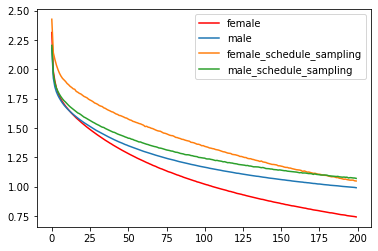

In [0]:
fig = plt.figure(1)         
ax = fig.add_subplot(111)
ax.plot(f,label='female',c='r')
ax.plot(m,label='male')
ax.plot(f_s,label='female_schedule_sampling')
ax.plot(m_s,label='male_schedule_sampling')
ax.legend()
fig.savefig('loss.png')

## Load demo

In [0]:
import numpy as np
import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence
import pickle

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 src_voc_size=9000,
                 trg_voc_size=9000,
                 src_embedding_size=256,
                 trg_embedding_size=256,
                 enc_hidden_size=200,
                 dec_hidden_size=200):
        
        super(Seq2Seq, self).__init__()
        self.trg_embedding_size = trg_embedding_size
        self.dec_hidden_size = dec_hidden_size
        
        self.src_embedder = nn.Embedding(src_voc_size , src_embedding_size)
        self.encoder = nn.LSTM(src_embedding_size ,enc_hidden_size,3, batch_first=True,dropout=0.5)
        
        self.trg_embedder = nn.Embedding(trg_voc_size , trg_embedding_size)
        self.decoder = nn.LSTM(trg_embedding_size ,dec_hidden_size,3, batch_first=True,dropout=0.5)
        self.cls = nn.Linear(dec_hidden_size , trg_voc_size)
    
    def forward(self,source,target,feed_previous=False):
        batch_size = source.size()[0]
        src_em = self.src_embedder(source)
        trg_em = self.trg_embedder(target)
        
        _ , enc_state = self.encoder(src_em)
        
        GO = Variable(torch.zeros(batch_size,1,self.trg_embedding_size))
        
        if feed_previous: #test phase
            logits_ = []
            inputs = GO
            h = enc_state
            for i in range(25):
                output , h = self.decoder(inputs,h)
                logits = self.cls(output.view(-1, self.dec_hidden_size))  # (1, vocab_size)
                logits_.append(logits)
                
                predicted = logits.max(1)[1]
                inputs = self.trg_embedder(predicted)
                    
            return torch.cat(logits_,0)
            
        else: #train phase
            dec_in = torch.cat([GO,trg_em[:,:-1,:]],1)
            outputs , _ = self.decoder(dec_in,enc_state)
            outputs = outputs.contiguous().view(-1,self.dec_hidden_size)
            logits = self.cls(outputs)
        
            return logits


In [0]:
female = Seq2Seq()
male = Seq2Seq()

In [0]:
female.load_state_dict(torch.load('model_female_cpu.pth'))
male.load_state_dict(torch.load('model_male_cpu.pth'))

In [0]:
female_sche = Seq2Seq()
female_sche.load_state_dict(torch.load('model_female_sche_samplling_cpu.pth'))

In [0]:
class Vocab:
    def __init__(self,idx2word,word2idx):
        self.idx2word = idx2word
        self.word2idx = word2idx
        self.max_len = 25
        self.eos_idx = 8002
        self.EN_WHITELIST  = '0123456789abcdefghijklmnopqrstuvwxyz '             
            
    '''
    idx -> word with EOS
    '''        
    def decode_line(self,sentence_idx,remove_pad=True,remove_eos=True):  #sentence_idx: 1d_matrix     
        sentence = []
        for w in sentence_idx:
            if remove_eos and w==self.eos_idx:
                continue
            if remove_pad and w==0 : 
                continue
            sentence.append(self.idx2word[w])
            #if w==self.eos_idx:
            #    break
        sentence = ' '.join(sentence)
        return sentence
    
    def decode(self,sentence_idxs,remove_pad=True,remove_eos=True): #sentence_idxs: 2d_matrix 
        sentences = []
        for s in sentence_idxs: 
            sentences.append(self.decode_line(s,
                                              remove_pad=remove_pad,
                                              remove_eos=remove_eos))
        return sentences
            
    '''
    word -> idx with EOS
    '''
    def encode_line(self,sentence):  #sentence: 1d_matrix
        sentence = sentence.lower()
        s_list = ''.join([ ch for ch in sentence if ch in self.EN_WHITELIST ]).split()
        sentence_idx = []
        for w in s_list:
            sentence_idx.append(self.word2idx[w])
        n = len(sentence_idx)
        if  n > self.max_len:
            sentence_idx = sentence_idx[:self.max_len] 
        elif n < self.max_len:
            sentence_idx = sentence_idx + [self.eos_idx] + [0]*(self.max_len-n-1)  
        return sentence_idx
    
    def encode(self,sentences): #sentences: 2d_matrix   
        sentence_idxs = []
        for s in sentences: 
            sentence_idxs.append(self.encode_line(s))
        return np.array(sentence_idxs)
    
    def print_QA(self, ques , pred_ans, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans[i] , strd_ans[i]]
            sents = vocab.decode(idxs,remove_eos=True,remove_pad=True)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[2])
            print('pred A :'+sents[1]) 
            
    def print_QA_1(self, ques , pred_ans_train, pred_ans_test, strd_ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i],  pred_ans_train[i], pred_ans_test[i] , strd_ans[i]]
            sents = vocab.decode(idxs,remove_eos=True,remove_pad=True)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[3])
            print('train A:'+sents[1])    
            print('test A :'+sents[2]) 
            
    def print_QA_2(self, ques , ans):
        n = len(ques)
        for i in range(n):
            idxs = [ ques[i], ans[i]]
            sents = vocab.decode(idxs)
            print('\nQ      :'+sents[0])  
            print('A      :'+sents[1])

In [0]:
with open('./metadata_1.pkl', 'rb') as f:
        metadata = pickle.load(f)
        
vocab = Vocab(metadata['idx2w'] , metadata['w2idx'])

In [0]:
lines = []
lines.append( 'you can do it'  )
lines.append( 'how are you'    )
lines.append( 'fuck you'  )
lines.append( 'jesus christ you scared the shit out of me'  )
lines.append( 'youre terrible'  )
lines.append( 'is something wrong' )
lines.append( 'nobodys gonna get inside' )
lines.append( 'im sorry'  )
lines.append( 'shut up'  )
N = len(lines)
lines = vocab.encode(lines)
q_o = Variable(torch.from_numpy(lines).long())
#vocab.decode(vocab.encode(lines))

In [0]:
female.eval()
o = female(q_o,q_o,feed_previous=True)
_,predict_o = o.max(1)
#vocab.decode(predict_o.cpu().view(-1,3).data.numpy().T)
pred_ans_o = predict_o.view(-1,N).data.numpy().T #predicted answer 
vocab.print_QA_2(lines, pred_ans_o)

In [0]:
male.eval()
o = male(q_o,q_o,feed_previous=True)
_,predict_o = o.max(1)
#vocab.decode(predict_o.cpu().view(-1,3).data.numpy().T)
pred_ans_o = predict_o.view(-1,N).data.numpy().T #predicted answer 
vocab.print_QA_2(lines, pred_ans_o)

In [0]:
female_sche.eval()
o = female_sche(q_o,q_o,feed_previous=True)
_,predict_o = o.max(1)
#vocab.decode(predict_o.cpu().view(-1,3).data.numpy().T)
pred_ans_o = predict_o.view(-1,N).data.numpy().T #predicted answer 
vocab.print_QA_2(lines, pred_ans_o)

In [0]:
def chat():
    while 1:
        #input_box
        r = raw_input('Question:To whom{m,f,_}')
        if ':' in r:
            x,m= r.split(':')
        else:
            x,m = r,''
        x,m = x.strip(), m.strip()
        if x=='' :
            break
        
        #decide model
        if m == 'm':
            model = male
        elif m== 'f':
            model = female
        else:
            model = female_sche
        
        #print answer
        lines = []
        lines.append( x )
        N = len(lines)
        lines = vocab.encode(lines)
        q_o = Variable(torch.from_numpy(lines).long()) 
        o = model(q_o,q_o,feed_previous=True)
        _,predict_o = o.max(1)
        pred_ans_o = predict_o.view(-1,N).data.numpy().T #predicted answer 
        vocab.print_QA_2(lines, pred_ans_o)
        print('')
        
    print('...end of conversation')


In [0]:
def two_gender_chatting(characters=['m','f']):

    
    #input_box
    r = raw_input('Srart conversation: ')
    x = r
    print('')

    for i in range(3):   
        for ch in characters: 
            #decide model
            if ch == 'm':
                model = male
                ch = 'm     '
            elif ch == 'f':
                model = female
                ch = 'f     '
            else:
                model = female_sche
                ch = 'f_sche'
                
            lines = vocab.encode([x])
            q_o = Variable(torch.from_numpy(lines).long()) 
            o = model(q_o,q_o,feed_previous=True)
            _,predict_o = o.max(1)
            pred_ans_o = predict_o.view(-1,1).data.numpy().T #predicted answer 
            x = vocab.decode(pred_ans_o)[0]
            print(ch+' :'+x)   
    
    print('\n...end of conversation')

In [0]:
chat()

In [0]:
two_gender_chatting(['f_s','f'])